In [118]:
import os
import random
import torch

import utils
import data_utils
import similarity

import matplotlib
from matplotlib import pyplot as plt

os.chdir("/volumes1/safeexplain/clip_diss/CLIP-dissect")


In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings

In [157]:
clip_name = 'ViT-B/16'
target_name = 'resnet18_cifar_t4'
target_layer = 'layer4'
d_probe = 'cifar100_val'
concept_set = 'data/cifar.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi
print('0')

0


## Run CLIP-Dissect

In [158]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

Files already downloaded and verified
Files already downloaded and verified


In [159]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 3171.87it/s]


torch.Size([512, 100])
Files already downloaded and verified


In [160]:
save_names

('saved_activations/cifar100_val_resnet18_cifar_t4_layer4.pt',
 'saved_activations/cifar100_val_ViT-B16.pt',
 'saved_activations/cifar_ViT-B16.pt')

In [161]:
target_feats.shape[1]

512

## Visualize Results

In [162]:
# neurons_to_check = ids_to_check = random.sample([i for i in range(target_feats.shape[1])], k=10)
# #neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]

# ranks = ["1st", "2nd", "3rd"]
# top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

# for orig_id in ids_to_check:

#     print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
#     vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
#     for i in range(len(vals)):
#         print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))
    
#     print("5 most highly activating images in D_probe:")
#     fig = plt.figure(figsize=(15, 7))
#     for i, top_id in enumerate(top_ids[:, orig_id]):
#         im, label = pil_data[top_id]
#         im = im.resize([375,375])
#         fig.add_subplot(1, 5, i+1)
#         plt.imshow(im)
#         plt.axis('off')
        
#     plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
#     plt.show()

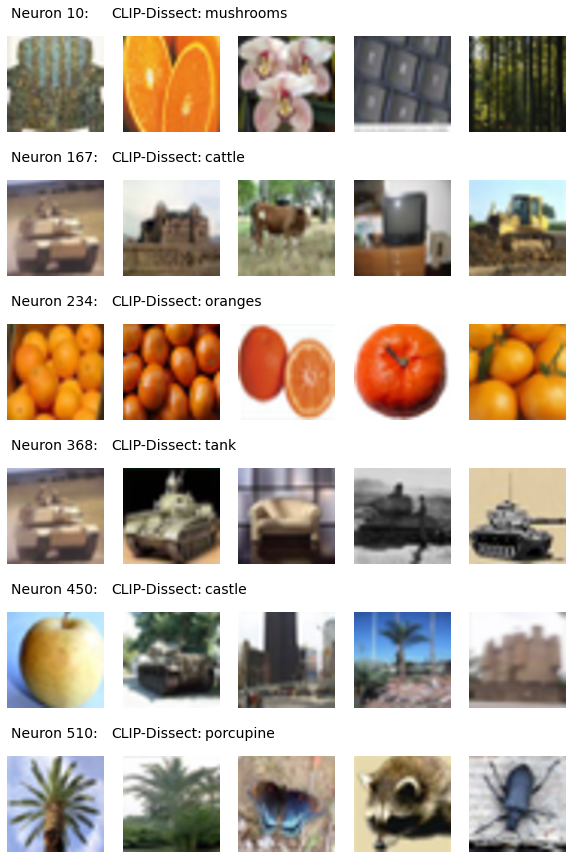

In [163]:
neurons_to_check = [10,167, 234, 368, 450, 510]
#torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
        
plt.show()
fig.savefig('/volumes1/safeexplain/clip_diss/CLIP-dissect/experiments/visual/{}.png'.format(target_name), bbox_inches = 'tight', dpi=500)